# Astronomical Telescopes and Instruments 2020: Exercise Set 11

Welcome to the eleventh (and final) exercise class for ATI 2020. You have to hand in the completed notebook to Brightspace before the start of the next lecture. Information/things to think about will be in regular font, while exercises will be *italic*.

### Make sure your submitted notebook works when run from scratch! You can do this using the menu above 'Kernel/Restart & Run all'. There should be no errors!

*Upload the finished notebook to Brightspace before the start of the next lecture!*

These are the packages you need for this exercise set. You are welcome to add extra, but this should not be necessary.

In [1]:
import numpy as np
import hcipy as hp
import matplotlib.pyplot as plt

%matplotlib inline

This set will have you look at how two coronagraphs work, and then using them to find a simulated exoplanet next to its star. There is only a single exercise in this set, which shouldn't take too long. Depending on how much effort you want to put in this set, you can make the planet dimmer compared to the star and still try to find it.

Before we start, some terms used in this notebook:
* Contrast: ratio of peak planet intensity to peak star intensity in an image.
* IWA (inner working angle): Smallest separation in the focal plane where the coronagraph is working (removing stellar light while letting planet light through). Typically given in $\lambda/D$.
* OWA (outer working angle): Largest separation where the coronagraph works. Also typically given in $\lambda/D$.

#### Starting variables

Like previous sets we start by defining our variables (it's quite a list today) and creating some basic objects.

In [2]:
# pupil plane
N = 512 # pixels in pupil plane
D = 1 # aperture diameter in m
os = 1.05 # oversize of pupil grid compared to aperture
F = 12 # focal ratio of pupil plane to focal plane

wl = 550E-9 # operating wavelength in m
f = F*D # focal length from pupil plane to focal plane
planet_contrast = 3E-5 # planet contrast to star
planet_tilt = np.array([-5,8]) # planet offset in focal plane in l/d

# focal plane
num_airy = 32 # l/d extent of focal plane
q = 8 # pixels per l/d
phys_scale = F*wl # physical size of 1 l/d

# APP (see below)
IWA_APP = 3 # inner working angle in l/d
OWA_APP = 25 # outer working angle in l/d
dark_hole_contrast = 1E-3 # desired contrast in the dark hole
num_iterations = 10 # optimization iterations for the APP, higher creates better designs but takes longer to run
beta = 0.4 # optimization parameter for creating the APP

# lyot (see even further below)
r_focal_stop = 0.75 # focal mask radius in l/d
r_lyot_stop = 0.45 # lyot stop radius in aperture diameter

In [3]:
# basic objects
pg = hp.make_pupil_grid(N, D*os)
fg = hp.make_focal_grid(q, num_airy, phys_scale)

A = hp.circular_aperture(D)
fraun = hp.FraunhoferPropagator(pg, fg, f)

# star and planet wavefronts
planet_phase = np.exp(1j*2*np.pi*(pg.points @ planet_tilt))
wf_star = hp.Wavefront(A(pg), wl)
wf_planet = hp.Wavefront(np.sqrt(planet_contrast) * A(pg) * planet_phase, wl)

The pupil plane we use has a higher resolution than in previous sets, this is to be able to create better APP designs below. The focal plane also covers more $\lambda/D$ than you might be used to thus far. Note that in the code above there is a wavefront for the star, but also for the planet. Without a coronagraph it is not possible to see this planet:

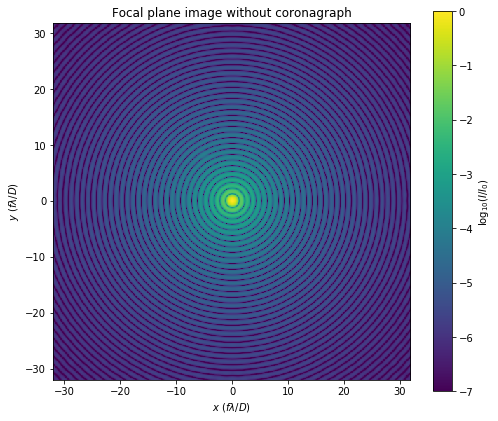

In [4]:
fwf_star = fraun.forward(wf_star)
fwf_planet = fraun.forward(wf_planet)

I_total = fwf_star.intensity + fwf_planet.intensity # star and planet are mutually incoherent
I0 = I_total.max()
I_total /= I0

plt.figure(figsize=(8,7))
hp.imshow_field(np.log10(I_total), grid_units = F*wl, vmin = -7, vmax = 0)
plt.colorbar(label = r"log$_{10}(I/I_0)$")
plt.xlabel(r"$x$ ($f\lambda/D$)")
plt.ylabel(r"$y$ ($f\lambda/D$)")
plt.title("Focal plane image without coronagraph")

plt.show()

#### Apodizing Phase Plate (APP)

One of the approaches to make a coronagraph is to modify the phase of a wavefront in the pupil plane to create a PSF which allows us to see planets. As you have seen in the exercises on adaptive optics, a phase error in the pupil plane distorts the image in the focal plane. Atmospheric errors are of course random and merely spread out the light in the focal plane without creating any structure. It is however possible to choose a phase pattern which creates a 'dark hole' in the Airy pattern. Inside this dark hole one can then look for planets. We have to start by generating a desired contrast pattern with the dark hole:

In [5]:
# create desired contrast map for APP
APP_contrast = hp.Field(np.ones(fg.size), fg)
m = (fg.as_('polar').r > IWA_APP*phys_scale)*(fg.as_('polar').r < OWA_APP*phys_scale)*(fg.x > 0)
APP_contrast[m] = dark_hole_contrast

This leads to the contrast map plotted in the next cell. In the second line of the above cell we used the '.as' method of a grid. This allows us to express the grid coordinates in a different coordinate system. In the above case, we converted the Cartesian grid ($x$,$y$) to a polar grid ($r$, $\theta$), allowing us to extract a radius from the origin for every point in the grid. Also note the use of a numpy mask, if you have never used these before see https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html for example. Here we multiply multiple masks to get the desired region.

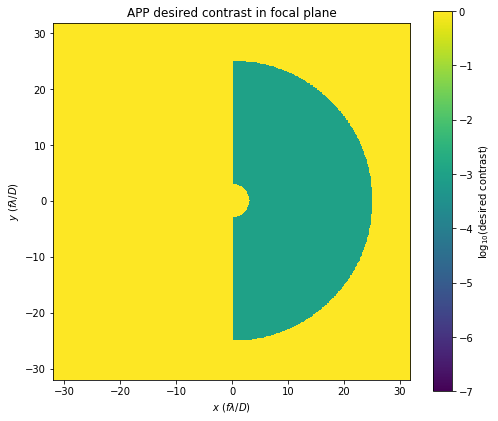

In [6]:
# plot desired contrast map
plt.figure(figsize=(8,7))
hp.imshow_field(np.log10(APP_contrast), grid_units = F*wl, vmax = 0, vmin = -7)
plt.xlabel(r"$x$ ($f\lambda/D$)")
plt.ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(label = r"log$_{10}($desired contrast$)$")
plt.title("APP desired contrast in focal plane")

plt.show()

The regions where the desired contrast is 1 is where we don't care about what contrast we reach. We can in principle make any choice we want for the desired contrast pattern, but some choices are harder to realize than others. Specifically note that near the center of the image (i.e. near the Airy core) we do not try to get a low contrast, as this leads to poor APP designs typically (the smaller your inner working angle, the harder it is to get good contrast in your dark zone as a general guideline). *hcipy* allows us to create a pupil plane phase pattern giving a PSF based on this desired contrast pattern:

In [7]:
def make_APP(pupil_aperture, desired_contrast, wavelength, propagator, num_iterations,  beta=0):
    '''
    Create an APP based on a desired contrast map and pupil aperture.
    
    Parameters
    ----------
    pupil_aperture : hp.Field
        Field containing the telescope aperture on which to make the phase pattern.
    desired_contrast : hp.Field
        Desired maximum contrast in the focal plane. The APP PSF will try to have a 
        relative intensity equal to or lower than the values in this Field.
    wavelength : scalar
        Operating wavelength.
    propagator : hp.Propagator
        Propagator to get from a pupil plane to a focal plane (such as a FraunhoferPropagator).
    num_iterations : int
        Number of iterations to optimize the APP design for. To reach deeper contrast this
        value must be increased, but this will also take longer to calculate.
    beta : scalar
        Value between 0 and 1 used in the optimization algorithm for the APP design. 
        Good values for beta are typically between 0.3 and 0.9. Default is 0.
        
    Returns
    -------
    APP : hp.Apodizer
        The APP given as an Apodizer optical element.
    '''
    wf_aperture = hp.Wavefront(pupil_aperture, wavelength)

    # create the APP phase pattern, this is the slow function
    APP_apodization = hp.generate_app_keller(wf_aperture, propagator, desired_contrast, num_iterations, beta=beta)

    # create Apodizer for the APP
    APP = hp.Apodizer(APP_apodization.electric_field)
    
    return APP

In [8]:
APP = make_APP(A(pg), APP_contrast, wl, fraun, num_iterations, beta)

The APP variable is an *Apodizer*, which is an optical element with a '.forward' method to propagate a wavefront through the APP. We get the following phase pattern for the APP and the corresponding PSF.

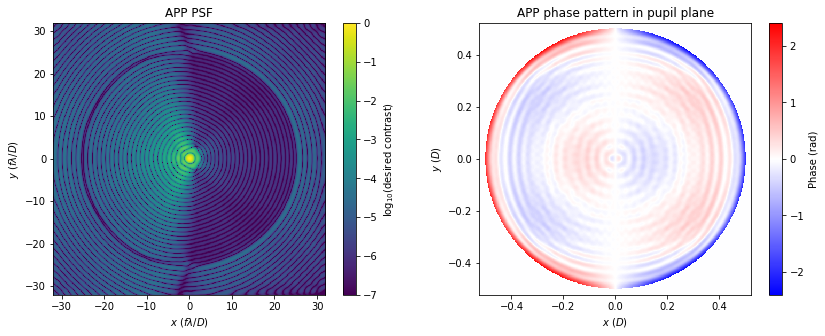

In [9]:
# propagate the stellar wavefront through the APP
APP_PSF = fraun.forward(APP.forward(wf_star))
P = APP_PSF.intensity
P /= I0

# plot results
fig, axs = plt.subplots(1,2, figsize =(14,5))
im = hp.imshow_field(np.log10(P), ax=axs[0], grid_units = F*wl, vmin = -7, vmax = 0)
axs[0].set_xlabel(r"$x$ ($f\lambda/D$)")
axs[0].set_ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(im, ax = axs[0], label = r"log$_{10}($desired contrast$)$")
axs[0].set_title("APP PSF")

im = hp.imshow_field(np.angle(APP.apodization), ax = axs[1], cmap = 'bwr', grid_units = D)
axs[1].set_xlabel(r"$x$ ($D$)")
axs[1].set_ylabel(r"$y$ ($D$)")
plt.colorbar(im, ax = axs[1], label = "Phase (rad)")
axs[1].set_title("APP phase pattern in pupil plane")

plt.show()

Note that because the APP works in the pupil plane, any point source will have a PSF that looks like this. In the case of a dim planet with PSF, only the core of the PSF is typically bright enough to be seen above the stellar PSF, so you do not see any of the substructure for the planet PSF.

#### Lyot coronagraph

A different way to remove stellar light is to block it in a focal plane, rather than altering a PSF in the pupil plane. The Lyot coronagraph follows the setup shown in the lecture, with a focal plane mask, followed by a pupil plane Lyot stop, then a final focal plane for the detector. Both the focal plane mask and Lyot stop are amplitude masks, meaning they block part of the light in their respective planes.

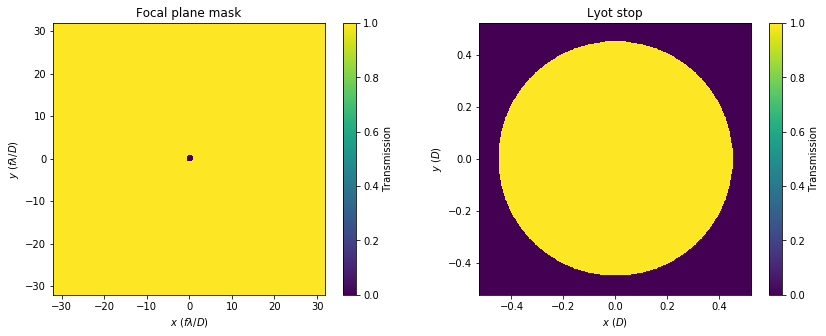

In [10]:
focal_plane_mask = hp.Field((fg.as_('polar').r > r_focal_stop*phys_scale).astype(float), fg)
lyot_stop = hp.Field((pg.as_('polar').r < r_lyot_stop*D).astype(float), pg)

fig, axs = plt.subplots(1,2, figsize =(14,5))
im = hp.imshow_field(focal_plane_mask, ax=axs[0], grid_units = F*wl)
axs[0].set_xlabel(r"$x$ ($f\lambda/D$)")
axs[0].set_ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(im, ax = axs[0], label = r"Transmission")
axs[0].set_title("Focal plane mask")

im = hp.imshow_field(lyot_stop, ax = axs[1], grid_units = D)
axs[1].set_xlabel(r"$x$ ($D$)")
axs[1].set_ylabel(r"$y$ ($D$)")
plt.colorbar(im, ax = axs[1], label = "Transmission")
axs[1].set_title("Lyot stop")

plt.show()

The focal plane mask blocks the central part of the stellar Airy pattern (therefore blocking most of the stellar light).

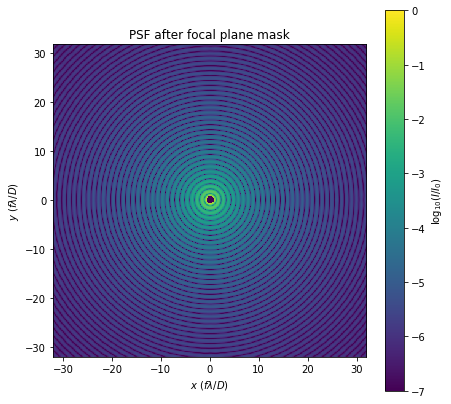

In [11]:
focal_apodizer = hp.Apodizer(focal_plane_mask)
lyot_apodizer = hp.Apodizer(lyot_stop)

lyot_focal_wf = focal_apodizer.forward(fraun.forward(wf_star))

plt.figure(figsize=(7,7))
hp.imshow_field(np.log10(lyot_focal_wf.intensity/I0+1E-7), grid_units = F*wl, vmin = -7, vmax = 0)
plt.xlabel(r"$x$ ($f\lambda/D$)")
plt.ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(label = r"log$_{10}(I/I_0)$")
plt.title("PSF after focal plane mask")

plt.show()

This leads to some scattered light in the next pupil plane, which is mostly blocked by the Lyot stop.

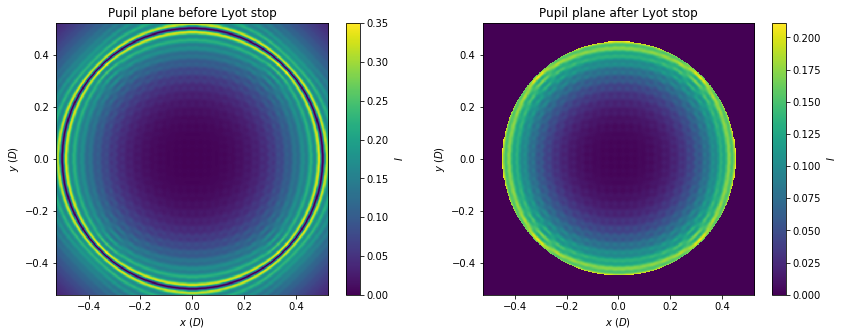

In [12]:
lyot_pupil_wf1 = fraun.backward(lyot_focal_wf)
lyot_pupil_wf2 = lyot_apodizer.forward(lyot_pupil_wf1)

fig, axs = plt.subplots(1,2, figsize =(14,5))
im = hp.imshow_field(lyot_pupil_wf1.intensity, ax=axs[0], grid_units = D, vmin=0)
axs[0].set_xlabel(r"$x$ ($D$)")
axs[0].set_ylabel(r"$y$ ($D$)")
plt.colorbar(im, ax = axs[0], label = r"$I$")
axs[0].set_title("Pupil plane before Lyot stop")

im = hp.imshow_field(lyot_pupil_wf2.intensity, ax = axs[1], grid_units = D, vmin=0)
axs[1].set_xlabel(r"$x$ ($D$)")
axs[1].set_ylabel(r"$y$ ($D$)")
plt.colorbar(im, ax = axs[1], label = r"$I$")
axs[1].set_title("Pupil plane after Lyot stop")

plt.show()

Note the difference in colorbar scale, showing we remove some of the remaining stellar light. The final focal plane then looks like this:

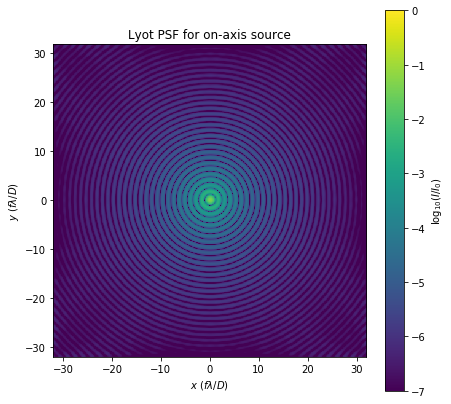

In [13]:
lyot_final_wf = fraun.forward(lyot_pupil_wf2)

plt.figure(figsize=(7,7))
hp.imshow_field(np.log10(lyot_final_wf.intensity/I0), grid_units = F*wl, vmin = -7, vmax = 0)
plt.xlabel(r"$x$ ($f\lambda/D$)")
plt.ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(label = r"log$_{10}(I/I_0)$")
plt.title("Lyot PSF for on-axis source")

plt.show()

The following function does this entire process in one go:

In [14]:
def lyot_coronagraph(input_wf, focal_plane_stop, lyot_stop, propagator):
    '''
    Propagate light through a Lyot coronagraph.
    
    Parameters
    ----------
    input_wf : hp.Wavefront
        Input wavefront.
    focal_plane_stop : hp.Field
        Focal plane transmission mask.
    lyot_stop : hp.Field
        Lyot stop transmission mask.
    propagator : hp.Propagator
        Propagator to go from pupil plane to focal plane.
        
    Returns
    -------
    hp.Wavefront
        Wavefront in the focal plane after the Lyot coronagraph.
    '''
    focal_apodizer = hp.Apodizer(focal_plane_stop)
    lyot_apodizer = hp.Apodizer(lyot_stop)
    
    wf_lyot = propagator.backward(focal_apodizer.forward(propagator.forward(input_wf)))
    wf_out = propagator.forward(lyot_apodizer.forward(wf_lyot))
    
    return wf_out

Now we finally get to the exercise:

*Using either the APP or Lyot coronagraph (or both if you feel like it), find the planet hidden in the stellar light and plot it. Alter the parameters of the given APP and Lyot coronagraph to do this. Motivate which coronagraph you choose. If you use the APP, also plot the contrast map you use to generate the APP. If you use the Lyot coronagraph, also plot the focal plane mask and Lyot stop mask.*

Some notes:
* You will have to propagate the star and planet wavefront separately through each coronagraph, then add the intensities to get the output image (as in the image without coronagraph at the start of the set). Think about why you have to do this.

* The parameters given for the Lyot and the APP do not show the planet with any reasonable SNR, so you will have to play around with either defining the desired contrast map for the APP, or the Lyot parameters. You have to change the shape of the APP contrast map if you use the APP, because the planet is not in the dark hole of the given contrast map.

* With the given planet contrast, it shouldn't be too difficult to find the planet. What is the smallest contrast you can give the planet so you can still see it in the coronagraphic image? There will be a **leaderboard** once all sets are graded.

* You are encouraged to change the planet contrast to make it as dim as possible, but you are not allowed to change the planet position.

* You may have noticed all the PSFs above were normalized to 'I0'. Please do the same for any focal plane intensity images you plot.

Some of the relevant parameters you can play around with are copied here:

In [56]:
# APP
IWA_APP = 3 # inner working angle in l/d
OWA_APP = 25 # outer working angle in l/d
dark_hole_contrast = 1E-3 # desired contrast in the dark hole
num_iterations = 10 # optimization iterations for the APP, higher creates better designs but takes longer to run
beta = 0.4 # optimization parameter for creating the APP

# lyot
r_focal_stop = 0.75 # focal mask radius in l/d
r_lyot_stop = 0.35 # lyot stop radius in aperture diameter

# planet
planet_contrast = 3e-5 # planet contrast to star
wf_planet = hp.Wavefront(np.sqrt(planet_contrast) * A(pg) * planet_phase, wl)

## My code

I use the Lyot coronagraph.

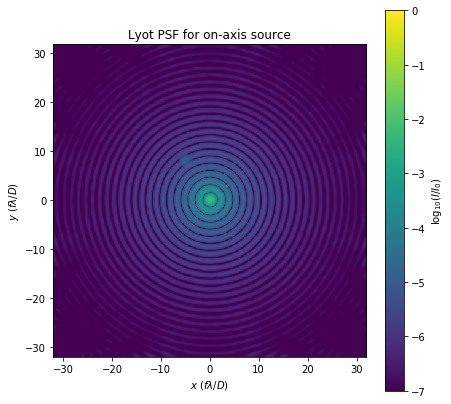

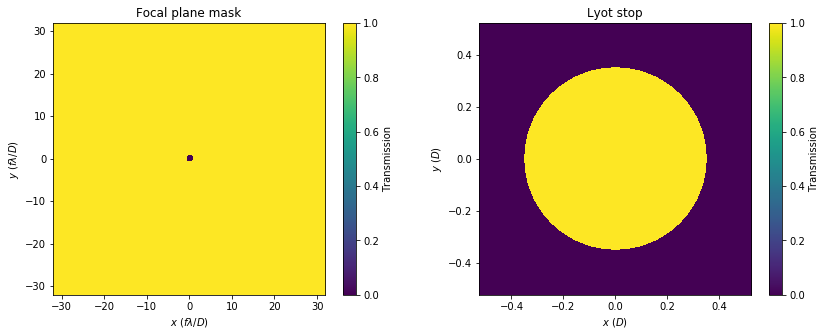

In [57]:
# First reload the focal plane mask and lyot stop with new values.
focal_plane_mask = hp.Field((fg.as_('polar').r > r_focal_stop*phys_scale).astype(float), fg)
lyot_stop = hp.Field((pg.as_('polar').r < r_lyot_stop*D).astype(float), pg)

# Load the wf_planet_out and wf_star_out.
wf_planet_out = lyot_coronagraph(wf_planet, focal_plane_mask, lyot_stop, fraun)
wf_star_out = lyot_coronagraph(wf_star, focal_plane_mask, lyot_stop, fraun)

# Plot them.
plt.figure(figsize=(7,7))
hp.imshow_field(np.log10((wf_planet_out.intensity + wf_star_out.intensity)/I0), grid_units = F*wl, vmin = -7, vmax = 0)
plt.xlabel(r"$x$ ($f\lambda/D$)")
plt.ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(label = r"log$_{10}(I/I_0)$")
plt.title("Lyot PSF for on-axis source")

fig, axs = plt.subplots(1,2, figsize =(14,5))
im = hp.imshow_field(focal_plane_mask, ax=axs[0], grid_units = F*wl)
axs[0].set_xlabel(r"$x$ ($f\lambda/D$)")
axs[0].set_ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(im, ax = axs[0], label = r"Transmission")
axs[0].set_title("Focal plane mask")

im = hp.imshow_field(lyot_stop, ax = axs[1], grid_units = D)
axs[1].set_xlabel(r"$x$ ($D$)")
axs[1].set_ylabel(r"$y$ ($D$)")
plt.colorbar(im, ax = axs[1], label = "Transmission")
axs[1].set_title("Lyot stop")

plt.show()

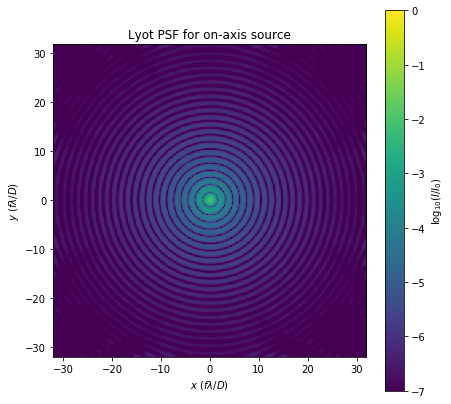

In [58]:
# planet
planet_contrast = 3e-6 # With this contrast it is still visible.
wf_planet = hp.Wavefront(np.sqrt(planet_contrast) * A(pg) * planet_phase, wl)

focal_plane_mask = hp.Field((fg.as_('polar').r > r_focal_stop*phys_scale).astype(float), fg)
lyot_stop = hp.Field((pg.as_('polar').r < r_lyot_stop*D).astype(float), pg)

wf_planet_out = lyot_coronagraph(wf_planet, focal_plane_mask, lyot_stop, fraun)
wf_star_out = lyot_coronagraph(wf_star, focal_plane_mask, lyot_stop, fraun)

plt.figure(figsize=(7,7))
hp.imshow_field(np.log10((wf_planet_out.intensity + wf_star_out.intensity)/I0), grid_units = F*wl, vmin = -7, vmax = 0)
plt.xlabel(r"$x$ ($f\lambda/D$)")
plt.ylabel(r"$y$ ($f\lambda/D$)")
plt.colorbar(label = r"log$_{10}(I/I_0)$")
plt.title("Lyot PSF for on-axis source")

plt.show()

With a contrast of 3e-6 the planet is barely visible.

### Make sure your submitted notebook works when run from scratch! You can do this using the menu above 'Kernel/Restart & Run all'. There should be no errors!

*Upload the finished notebook to Brightspace before the start of the next lecture!*